# #01 Challenge | Delhi's Air Quality Data

We are starting the biweekly series of challenges in this Study Circle. After considering the topics you have suggested in the comments, we are kicking off with Time Series.

## Why this Data topic?

This morning, I read the Economist Espresso on [India's pollution season](https://espresso.economist.com/0ef63386fdcb3dc2c2914b319668ff81), and I thought it was a good idea to start the series of challenges with this topic.

## Getting the Data

After navigating many websites, such as India's [Central Pollution Control Board](https://cpcb.nic.in/National-Air-Quality-Index/) and WHO, I found [this website](https://aqicn.org/data-platform/register/) about Air Quality Data, where we can download the data from many places worldwide.

I chose Delhi to be the city we will analyse in this challenge.

Executing the following lines of code will produce the DataFrame we'll work with:

In [87]:
import pandas as pd

url_data = 'https://raw.githubusercontent.com/jsulopzs/Aigents-Python-Data-Science-Challenges/master/01%20India%20Air%20Pollution/anand-vihar%2C%20delhi-air-quality.csv'

df = pd.read_csv(url_data, parse_dates=['date'], index_col=0)
df

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2022-10-01,176,436,17,38,8,10
2022-10-02,171,344,17,43,4,15
...,...,...,...,...,...,...
2014-08-07,,,22,41,6,6
2021-07-31,,,,11,4,12


I needed to process the data to deliver a workable dataset in the following way:

In [2]:
#remove whitespaces in columns
df.columns = df.columns.str.strip()

#get the rows with the numbers (some of them where whitespaces)
series = df['pm25'].str.extract('(\w+)')[0]

#rolling average to armonize the data monthly
series_monthly = series.rolling(int((52*7)/12)).mean()

#remove missing dates
series_monthly = series_monthly.dropna()

#fill missing dates by linear interpolation
series_monthly = series_monthly.interpolate(method='linear')

#sorting the index to later make a reasonable plot
series_monthly = series_monthly.sort_index()

#aggregate the information by month
series_monthly = series_monthly.to_period('M').groupby(level='date').mean()

#process a timestamp to avoid errors with statsmodels' functions
series_monthly = series_monthly.to_timestamp()

#setting freq to avoid errors with statsmodels' functions
series_monthly = series_monthly.asfreq("MS").interpolate()

#change the name of the pandas.Series
series_monthly.name = 'air pollution pm25'

As we don't know the coding skills of this Study Circle member, we'll start with simple ARIMA models. From this point, we will iterate the procedure and improve the dynamic.

To take on the challenge and maybe, receive some feedback, you should fork this repository to your GitHub account. Otherwise, you can download this script.

The end goal is to develop an ARIMA model and plot the predictions against the actual data. Resulting in a [plot like the this](https://github.com/jsulopzs/Aigents-Python-Data-Science-Challenges/blob/master/01%20India%20Air%20Pollution/final_plot.jpg).

Nevertheless, you can develop this challenge in any way you find attractive. The essential point of this Study Circle is the interactivity between the members to generate value and knowledge.

From your feedback, we could later work on different use cases. For example, we could later create a geospatial map in Python with the predictions.

So, let's get on and good luck!

You start with the following object:

## Learning Materials

Check out the following materials to learn how you could develop the challenge:

- [Video Tutorial](https://www.youtube.com/watch?v=gqryqIlvEoM): How to develop ARIMA models to predict Stock Price

## Start the challenge

In [3]:
series_monthly

date
2014-01-01    286.023457
2014-02-01    281.428205
                 ...    
2022-08-01    115.487097
2022-09-01    143.713333
Freq: MS, Name: air pollution pm25, Length: 105, dtype: float64

It's not the same to observe the data in numbers than in a chart:

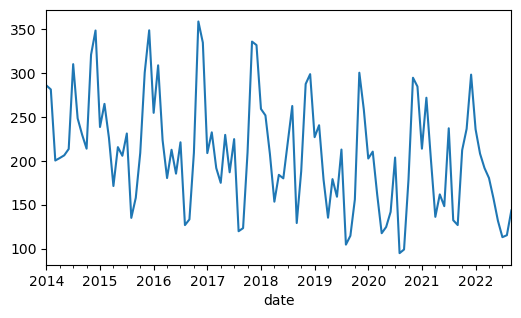

In [4]:
series_monthly.plot();

We aim to compute a mathematical equation that we will later use to calculate predictions, as we can see in the following chart:

![](final_plot.jpg)

There are many types of mathematical equations, the one we will use is `ARIMA`. Don't worry about the maths, we just need a Python function to make all for us.

In [13]:
from statsmodels.tsa.arima.model import ARIMA

The [parameters of this Class](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html) ask for two objects:

1. `endog`: the data
2. `order`: (p,d,q)
    1. `p`: the first significant lag in the Autocorrelation Plot
    2. `d`: the diff needed to make our data stationary
    3. `q`: the first significant lag in the Partial Autocorrelation Plot

### `d` | Diff to get data stationarity

The first thing we need to check about our data is the stationarity. We use the Augmented Dickey-Fuller test with the intention to reject the null hypothesis in which we state that the data is non-stationary. If that's the case, we need to differentiate the time series and adjust the number `d:1` in the parameter `order=(p, d:1, q)`.

In [76]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(series_monthly)

The p-value is given by the second element the function `adfuller` returns:

In [77]:
result[1]

0.4244071993737921

The p-value is greater than 0.05. Therefore, we can't reject the null hypothesis.

Are we done here?

- No, we can differentiate the Time Series by one lag and test again:

In [79]:
series_monthly_diff_1 = series_monthly.diff().dropna()

result = adfuller(series_monthly_diff_1)
result[1]

2.4066471086483724e-24

Now we can reject the null hypothesis and say that our data is stationary with a lag of 1. Therefore, we need to set `d:1` in the `order` parameter of the `ARIMA()` class.

### `q` | Autocorrelation Plot

Now we need to determine `q` based on the first significant lag of the autocorrelation plot:

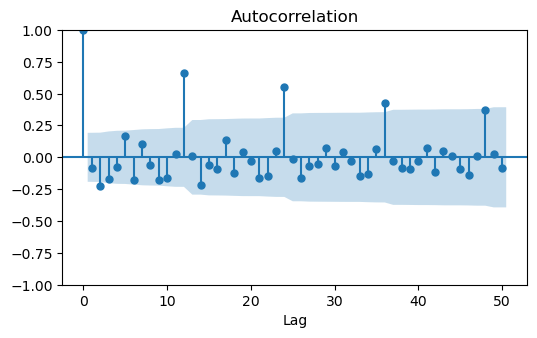

In [80]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(series_monthly_diff_1, lags=50)
plt.xlabel('Lag');

The first significant lag is the 2, which means that our data (monthly) is correlated on a yearly basis. We set `q=2`.

### `p` | Partial Autocorrelation Plot

We follow the same procedure to choose a number for `p`. But this time we use another type of plot: the Partial Autocorrelation.

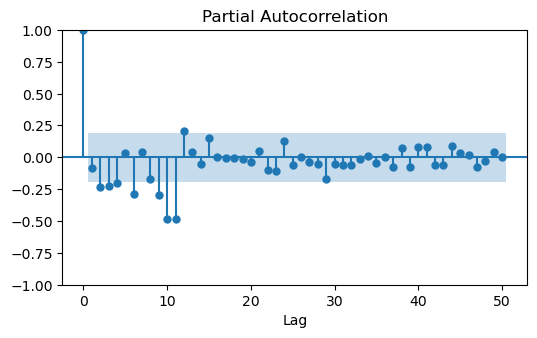

In [84]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(series_monthly_diff_1, lags=50, method='ywm')
plt.xlabel('Lag');

We see the first significant lag at 1. Therefore, we set `q=2`.

We already know which numbers we set on the `order` parameter: `order=(p:2, d:1, q:2)`. So, let's fit the mathematical equation of the model.

In [85]:
model = ARIMA(series_monthly, order=(2,1,2))

result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     air pollution pm25   No. Observations:                  105
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -561.398
Date:                Fri, 04 Nov 2022   AIC                           1132.797
Time:                        11:51:55   BIC                           1146.019
Sample:                    01-01-2014   HQIC                          1138.153
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2034      0.246     -0.826      0.409      -0.686       0.279
ar.L2          0.2482      0.214      1.162      0.245      -0.170       0.667
ma.L1         -0.1650      0.182     -0.906      0.365      -0.522       0.192
ma.L2         -0.7627      0.195     -3.921      0.000      -1.144      -0.381
sigma2      2811.0858    445.144      6.315      0.000    1938.619    3683.553
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.33
Prob(Q):                              0.92   Prob(JB):                         0.11
Heteroskedasticity (H):               0.91   Skew:                             0.42
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

And calculate the predictions:

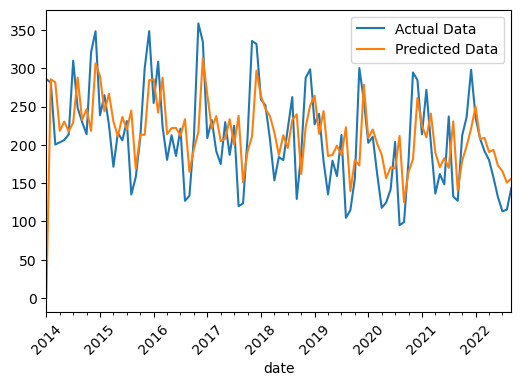

In [86]:
plt.figure(figsize=(6,4))
series_monthly.plot(label='Actual Data')
result.predict().plot(label='Predicted Data')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('final_plot.jpg', dpi=150)